# random_forest
- Implementation of random forest to investigate relative importance of morphology, stellar mass, inclination, along with local and large-scale environment on galaxy spin.
- Justification for choice of morphology/galaxy type (in this case actually $n_{sersic}$) parameter can be found in ./evalutate_morphology_params.ipynb
- Univariate correlations between key parameters can be found in ./univariate_correlations.ipynb with stellar mass and $n_{sersic}$ being the top two.

In [1]:
# general
import numpy as np
import pandas as pd
from scipy import stats

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# catalog class and associated libs.
import catalog
import encode_morphology
import plot_correlations

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot

### Loading in galaxy information using catalog class object

In [2]:
basepath = '../../catalogues/'
outpath = '../../plots/random_forest/'

# initiating catalog class objects.
galaxies = catalog.Catalog(basepath, version='mpl9', match_to_lim=True)
# matching to cw d|efinitions and selecting centrals only.
galaxies.match_to_cw(basepath, version='mpl9', sigma=3)

In [3]:
# creating group membership binary (0 - central, 1 - satellite) flag.
group_flag = np.zeros(galaxies.df.shape[0])

group_flag[galaxies.df.galaxyID.values == galaxies.df.cenID.values] = 0
group_flag[galaxies.df.galaxyID.values != galaxies.df.cenID.values] = 1

# adding flag to df
galaxies.df['group_flag'] = group_flag.astype(int)
galaxies.df.head(5)

,CATALOG_RA,CATALOG_DEC,NSA_Z,MANGAID_x,ID,GalID,px,py,pz,log_dskel,...,e_vel_sigma_Re,Lambda_Re,e_Lambda_Re,plate_y,ifudsgn_y,nsa_elpetro_mass_logscale,log_dskel_norm,log_dwall_norm,log_dnode_norm,group_flag
0,159.827061,0.839858,0.065915,1-3019,147,15113,-275.382448,101.173331,4.300716,0.043255,...,0.097637,0.097408,0.154860,10837,6102,10.922176,-0.728546,-0.756051,0.037368,0
1,160.143696,0.817429,0.065825,1-3050,148,12121,-273.812275,98.882583,4.153580,-0.878621,...,0.088168,0.642676,0.225280,10837,3701,10.888331,-1.649340,-0.711134,1.572121,1
2,160.760696,0.905083,0.125503,1-3087,150,58783,-512.637809,178.913657,8.577672,-0.013595,...,0.124708,0.085910,0.246711,10837,3703,11.068974,-0.986655,-1.382987,-1.070399,0
3,160.966486,1.061669,0.115905,1-3343,165,73456,-481.467757,166.097729,9.438687,-0.460942,...,0.084244,0.275265,0.129037,10837,3704,11.179978,-1.386935,-1.763926,-0.896978,0
4,203.752677,-0.447620,0.021990,1-10808,570,144684,-92.891861,-40.878621,-0.792863,-0.194282,...,0.268645,0.565687,0.931179,11024,3703,8.687317,-0.766828,-0.645687,-0.128733,0


### Creating individual features and label dfs.

In [4]:
labels = galaxies.df.Lambda_Re.values
features = galaxies.df[['nsa_elpetro_mass_logscale', 
                        'nsa_elpetro_ba',
                        'nsa_sersic_n',
                        'log_halo_mass', 
                        'group_flag', 
                        'log_dnode_norm', 
                        'log_dskel_norm']]

# for plotting.
feature_labels = np.array(['$M_{stel}$',
                           'Inc. (b/a)',
                           '$n_{sersic}$',
                           '$M_{halo}$',
                           'Cen/Sat',
                           '$D_{node}$',
                           '$D_{skel}$'])

### Using sklearn to divide into train and testing samples (to sanity check fit)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(features), labels, test_size = 0.2, 
                                                    shuffle=True, random_state = 27)
y_train.shape, y_test.shape

((4893,), (1224,))

In [6]:
X_train[:, 0:2].shape

(4893, 2)

### Grid search to find heurestic hyperparameters for the problem.
- running gridsearch with n_jobs = -2 (because it seems to crash for all other options ?)


In [7]:
# Number of trees in random forest
n_estimators = [500, 750, 1000, 1250]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [10, 50, 110]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

random_grid

{'n_estimators': [500, 750, 1000, 1250],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 50, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]}

In [8]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores (-2 since otherwise crashes)
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2,
                               n_jobs=-2)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done  19 tasks      | elapsed:   27.1s
/opt/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-2)]: Done 140 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed:  4.8min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-2,
                   param_distributions={'max_depth': [10, 50, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [500, 750, 1000, 1250]},
                   verbose=2)

In [9]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10}

### Using best forest estimator to make new set of predictions

In [10]:
best_random = rf_random.best_estimator_

# Use the forest's predict method on the test data
best_predictions = best_random.predict(X_test)

# Calculate the absolute errors
best_errors = np.abs(best_predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(best_errors), 5))

Mean Absolute Error: 0.12531


### Importance ranking of variables

In [16]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)

for feat, imp in zip(features.columns, importances):
    print(feat + ': {}'.format(imp))

nsa_elpetro_mass_logscale: 0.13812367923373156
nsa_elpetro_ba: 0.20253517282816813
nsa_sersic_n: 0.49035291092005207
log_halo_mass: 0.07603396883700904
group_flag: 0.00885557997791686
log_dnode_norm: 0.04122715839912128
log_dskel_norm: 0.04287152980400114


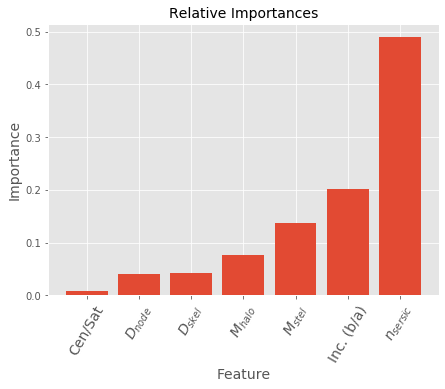

In [17]:
plt.style.use('ggplot')
fig, ax = plot_correlations.importance_ranking(feature_labels, importances)
ax.set_title('Relative Importances', fontsize=14)
plt.savefig(outpath + 'importances.pdf', format='pdf', bbox_inches='tight')

### Generating random forest only using top two parameters to evaluate additional information everything else brings

In [18]:
f_top = galaxies.df[['nsa_elpetro_ba', 'nsa_sersic_n']]
rf_top = RandomForestRegressor()
rf_top.set_params(**rf_random.best_params_)
rf_top.fit(X_train[:, 1:3], y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=1000)

In [19]:
# Use the forest's predict method on the test data
best_top_predictions = rf_top.predict(X_test[:, 1:3])

# Calculate the absolute errors
best_top_errors = np.abs(best_top_predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(best_top_errors), 5))

Mean Absolute Error: 0.12937


### Additional parameters (stellar mass, local and large scale environment) does improve predictive power, however, minimal relative to inclination and sersic index.
- Plotting $\lambda_R$ distributions for actual, predicted (all param), and predicted (top 2 params).

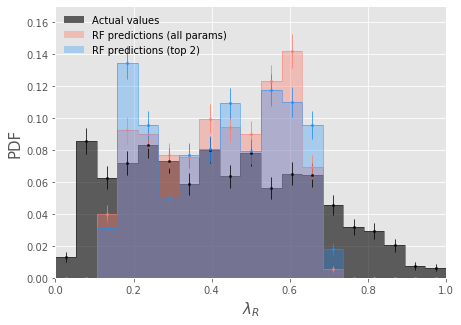

In [39]:
bins = np.linspace(0, 1, 20)

fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot()

plot_correlations.normed_step_poisson_histogram(y_test, bins=bins, color='k', label='Actual values', alpha=0.6, 
                                                ax=ax)
plot_correlations.normed_step_poisson_histogram(y_test, bins=bins, color='k', label=None, 
                                                histtype='step', alpha=.8, ax=ax)

plot_correlations.normed_step_poisson_histogram(best_predictions, bins=bins, color='salmon', ax = ax,
                                                label='RF predictions (all params)', alpha=0.4)
plot_correlations.normed_step_poisson_histogram(best_predictions, bins=bins, color='salmon', ax = ax,
                                                histtype='step', label=None)

plot_correlations.normed_step_poisson_histogram(best_top_predictions, bins=bins, color='dodgerblue', ax=ax,
                                                label='RF predictions (top 2)', alpha=0.3)
plot_correlations.normed_step_poisson_histogram(best_top_predictions, bins=bins, color='dodgerblue', ax = ax,
                                                histtype='step', label=None)

ax.legend(frameon = False, )
ax.set_ylabel('PDF', fontsize=15)
ax.set_xlabel('$\lambda_R$', fontsize=15)
ax.set_ylim([0, 0.17])
ax.set_xlim([0, 1])
plt.savefig(outpath + 'lambda_R_predicted_actual_distn.png', format='png', bbox_inches='tight')

### Plotting individual correlations (with corr. coefficient) between predictions and actual values.

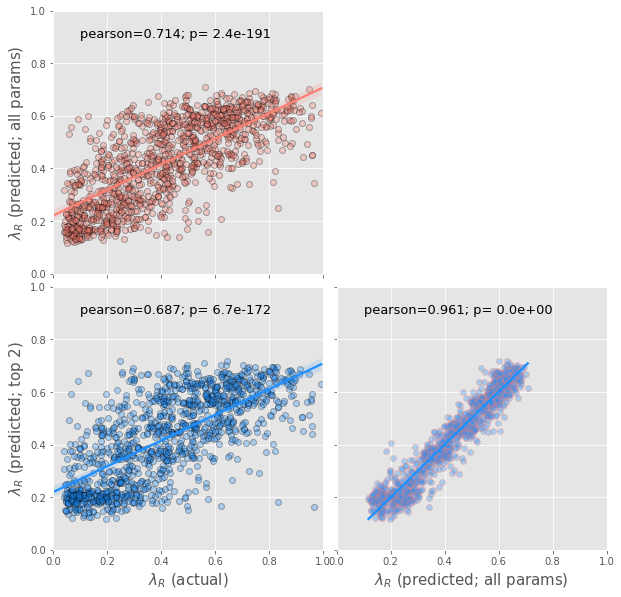

In [44]:
# throwing into a dataframe
pre_df = pd.DataFrame({'actual': y_test, 
                       'pre_all': best_predictions,
                       'pre_two': best_top_predictions})

# defining column names
cols = ['actual', 'pre_all', 'pre_two']
names = ['$\lambda_{R}$ (actual)', '$\lambda_{R}$ (predicted; all params)', '$\lambda_{R}$ (predicted; top 2)']
colors = ['k', 'salmon', 'dodgerblue']
limits = [[0, 1], [0, 1], [0, 1]]

fig, ax = plot_correlations.correlation_corner(pre_df, cols, colors, names=names, coef='pearson', limits=limits)
plt.savefig(outpath + 'lambda_R_predicted_actual_correlation_corner.png', format='png', 
            bbox_inches='tight', dpi=200)